Importing Libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

  Loading Dataset

In [2]:
# Define transformations for CIFAR-10 (Normalise and Augment)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Data Augmentation
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1,1]
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# DataLoader
batch_size = 64
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]


CNN Model

In [3]:
# Define CNN model
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

    self.pool = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(0.5)

    self.fc1 = nn.Linear(128 * 4 * 4, 256)  # FC layer
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 10)  # 10 output classes (CIFAR-10)

  def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = self.pool(F.relu(self.conv3(x)))

      x = x.view(-1, 128 * 4 * 4)  # Flatten
      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = F.relu(self.fc2(x))
      x = self.fc3(x)  # No softmax as CrossEntropyLoss applies it

      return x

In [ ]:
# Instantiate model
model = CNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 10
learning_rate = 0.001  # Lower LR for stable training
momentum = 0.9  # momentum value

# Instantiate the CIFAR-10 model
network = CNN()

# Use Adam optimizer
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

train_losses = []
test_accuracies = []

Training the model

In [ ]:
def train(epoch):
    network.train()
    running_loss = 0.0

    for batch_idx, (data, labels) in enumerate(trainloader):
        data, labels = data, labels

        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(trainloader.dataset)} '
                  f'({100. * batch_idx / len(trainloader):.0f}%)]\tLoss: {loss.item():.6f}')

    avg_loss = running_loss / len(trainloader)

    if epoch <= num_epochs:
      train_losses.append(avg_loss)  # Store only if within epoch range

    print(f"Epoch {epoch} finished with average loss: {avg_loss:.4f}")

    scheduler.step()

# Test function to calculate accuracy after each epoch
def test():
    correct = 0
    total = 0
    network.eval()
    with torch.no_grad():
        for data, labels in testloader:
            data, labels = data, labels
            outputs = network(data)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)  # Store accuracy
    print(f"Test Accuracy: {accuracy:.2f}%\n")

In [7]:
# Train and evaluate
for epoch in range(1, num_epochs + 1):
    train(epoch)
    test()

print("Training complete!")

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.299712
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.950332
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.758822
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.631614
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.648703
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.639935
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.558487
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.286930
Epoch 1 finished with average loss: 1.6332
Test Accuracy: 52.31%

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.363390
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.352007
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.224735
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.133821
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.289296
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.275434
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.283985
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.039931
Epoch 2 finished with average loss: 1.2551
Test Accuracy: 61.20%

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.029498
Train Epoch: 3 [6400/50000 (13%)]	L

Analysis of accuracy

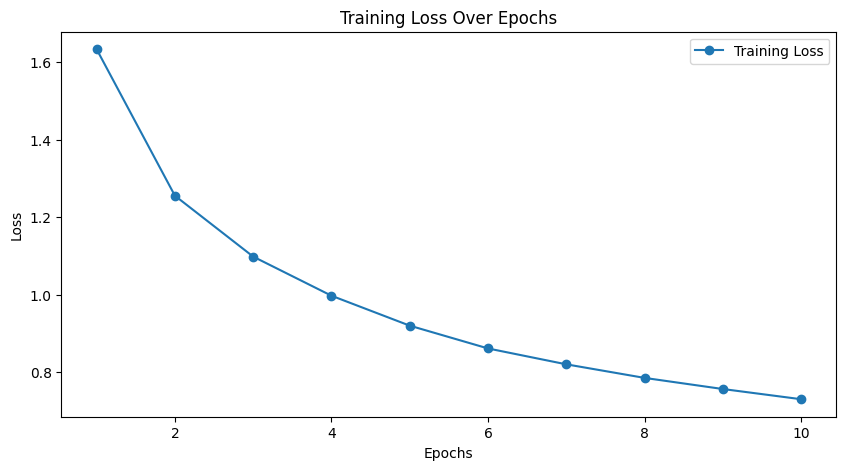

In [8]:
import matplotlib.pyplot as plt

# Plot Loss Graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()


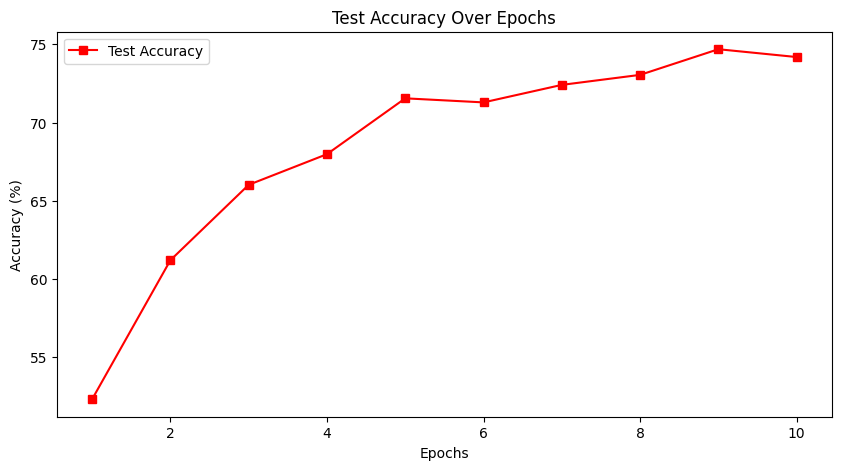

In [9]:
# Plot Accuracy Graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), test_accuracies, marker='s', linestyle='-', color='red', label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy Over Epochs")
plt.legend()
plt.show()